In [1]:
import numpy as np
from skimage import io
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
import src.plots
import src.models

In [2]:
plt.rcParams.update({'font.size': 16})

In [3]:
!ls data

sat.trn sat.tst


In [4]:
train, test = np.loadtxt('data/sat.trn'), np.loadtxt('data/sat.tst')

In [5]:
train

array([[ 92., 115., 120., ..., 113.,  87.,   3.],
       [ 84., 102., 106., ..., 104.,  79.,   3.],
       [ 84., 102., 102., ..., 104.,  79.,   3.],
       ...,
       [ 68.,  75., 108., ..., 104.,  85.,   4.],
       [ 71.,  87., 108., ..., 104.,  85.,   4.],
       [ 71.,  91., 100., ..., 100.,  81.,   4.]])

In [6]:
test

array([[ 80., 102., 102., ..., 113.,  87.,   3.],
       [ 76., 102., 102., ..., 104.,  83.,   3.],
       [ 80.,  98., 106., ...,  96.,  75.,   4.],
       ...,
       [ 56.,  68.,  91., ...,  92.,  74.,   5.],
       [ 56.,  68.,  87., ...,  92.,  70.,   5.],
       [ 60.,  71.,  91., ..., 108.,  92.,   5.]])

In [7]:
print(train.shape, test.shape)

(4435, 37) (2000, 37)


In [8]:
# Separate labels into different vectors
y_train, y_test = train[:,-1].astype('int'), test[:,-1].astype('int')

In [9]:
y_train, y_test

(array([3, 3, 3, ..., 4, 4, 4]), array([3, 3, 4, ..., 5, 5, 5]))

In [10]:
print(len(y_train), len(y_test))

4435 2000


In [11]:
# Separate 3x3x4 pixel neighborhood samples into train and test feature samples
X_train, X_test = train[:,:-1], test[:,:-1]

In [12]:
X_train

array([[ 92., 115., 120., ..., 107., 113.,  87.],
       [ 84., 102., 106., ...,  99., 104.,  79.],
       [ 84., 102., 102., ...,  99., 104.,  79.],
       ...,
       [ 68.,  75., 108., ..., 100., 104.,  85.],
       [ 71.,  87., 108., ...,  91., 104.,  85.],
       [ 71.,  91., 100., ...,  91., 100.,  81.]])

## Exploratory Data Analysis

In [13]:
# Determine class count for each label in training set
def class_counts(y):
    labels, labels_inverse, label_counts = np.unique(y, return_inverse=True, return_counts=True)
    return labels, labels_inverse, label_counts

In [14]:
labels, labels_inverse, label_counts = class_counts(y_train)

<ipython-input-15-8ded52a36041>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);


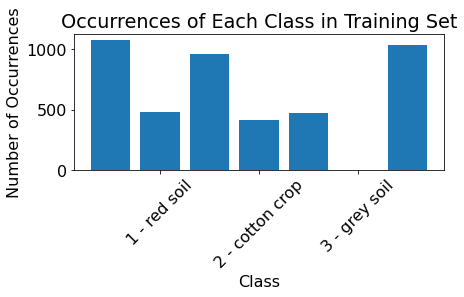

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(labels, label_counts)
ax.set_xlabel('Class')
ax.set_ylabel('Number of Occurrences')
ax.set_title('Occurrences of Each Class in Training Set')
ax.set_xticklabels(['','1 - red soil', '2 - cotton crop', '3 - grey soil', '4 - damp grey soil', '5 - soil w/veg.', '6 - mixture', '7 - very damp grey soil'], rotation=45);

plt.tight_layout()
#plt.savefig('imgs/train_class_count.png')

## Baseline Model

In [16]:
class Baseline():
    
    def __init__(self):
        self.classes_ = None
        self.classes_inverse_ = None
        self.means_ = None
        self.mean_dict = None
        self.label_dict = None

    def euclidean_distance(a,b):
        return np.sqrt(sum((a-b)**2))
    
    def predict(self, X):
        predicts = []
        self.label_dict = {num:label for num,label in zip(np.arange(len(self.classes_)), self.classes_)}
        for sample in X:
            mean_index = np.argmin([euclidean_distance(sample, mean_vector) for mean_vector in self.mean_dict.values()])
            predicts.append(self.label_dict[mean_index])
        return np.array(predicts)
    
    def fit(self, X_train, y_train):
        self.classes_, self.classes_inverse_ = np.unique(y_train, return_inverse=True)
        self.means_ = [np.mean(X_train[self.classes_inverse_==idx,:], axis=0) for idx,label in enumerate(self.classes_)]
        self.mean_dict = {label: self.means_[i] for i,label in enumerate(self.classes_)}
        

In [17]:
base_model = src.models.Baseline()
base_model.fit(X_train[:,16:20], y_train)

In [18]:
y_test_predict = base_model.predict(X_test[:,16:20])

In [21]:
print(f'Baseline Model Accuracy: {accuracy_score(y_test,y_test_predict)}') # Baseline model accuracy

Baseline Model Accuracy: 0.7685


## Neural Network

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

enc.fit(y_train.reshape(-1,1))

y_trn_1hot = enc.transform(y_train.reshape(-1,1)).toarray()


In [ ]:
# Scale the training data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_trn_scaled = scaler.transform(X_train)


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0005)
hidden_units = 100
n_classes = 6

In [ ]:
def create_model(X, n_classes, opt='Adam', hidden_units=100, drop_out=0, activ='softsign'):
    np.random.seed(42)

    n_samples, n_feats = X.shape

    model = Sequential() # sequence of layers

    hidden_layer = Dense(units=hidden_units,
                    input_dim=n_feats,
                    kernel_initializer='constant',
                    activation=activ)

    hidden_layer_2 = Dense(units=hidden_units,
                    kernel_initializer='constant',
                    activation=activ)

    outputlayer = Dense(units=n_classes,
                    input_dim=hidden_units,
                    kernel_initializer='uniform',
                    activation='softmax')

    model.add(hidden_layer)
    model.add(Dropout(drop_out))
    model.add(hidden_layer_2)
    model.add(Dropout(drop_out))
    model.add(hidden_layer_2)
    model.add(Dropout(drop_out))
    model.add(outputlayer)

    model.compile(loss='categorical_crossentropy', 
                  optimizer=opt, metrics=["accuracy"])
    return model

In [ ]:
model = create_model(X_trn_scaled, n_classes, opt)

In [ ]:
history = model.fit(X_trn_scaled, y_trn_1hot, epochs=350, batch_size=50, verbose=1, validation_split=0)


In [ ]:
history.history

In [ ]:
fig, ax = plt.subplots()
ax.plot(history.epoch, history.history['accuracy'], label = '3 hidden layers - train')
#ax.plot(history.epoch, history.history['val_accuracy'], label = '3 hidden layers - val')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per Epoch')
ax.legend()

In [ ]:
model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())  # Calculate performance metrics on unseen test data

### Decision Tree Classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_train, y_train)
yhat_trn = clf_dt.predict(X_train)
print(accuracy_score(y_train, yhat_trn))
yhat = clf_dt.predict(X_test)
print(accuracy_score(y_test, yhat))

1.0
0.8545


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Confusion Matrix
conf_mx = confusion_matrix(y_test, yhat, labels=clf_dt.classes_)
np.round(conf_mx, 2)
cm_display = ConfusionMatrixDisplay(conf_mx, display_labels=clf_dt.classes_).plot(cmap='plasma')

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [ ]:
clf_dt.classes_

In [ ]:
np.fill_diagonal(conf_mx, 0)
plt.matshow(conf_mx, cmap=plt.cm.gray)

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=100, max_depth=50, random_state=0, class_weight='balanced')
clf.fit(X_train, y_train)
y_trn_rf = clf.predict(X_train)
print(f'Train Accuracy: {accuracy_score(y_train, y_trn_rf)}')
y_rf = clf.predict(X_test)
print(f'Test Accuracy: {accuracy_score(y_test, y_rf)}')

## Grid Search

### Neural Network Search

In [ ]:
modelo = keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, X=X_trn_scaled, n_classes=6, opt=opt)

In [ ]:
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid']

In [ ]:
# Set grid search parameters
param_grid = dict(epochs=[350, 400], batch_size=[40], drop_out = [0,0.05,0.1], activ=activation)
grid = GridSearchCV(estimator=modelo, param_grid=param_grid, n_jobs=-1, cv=[(slice(None), slice(None))])
grid_result = grid.fit(X_trn_scaled, y_trn_1hot)

In [ ]:
grid_result.best_params_

In [ ]:
grid_result.best_score_

In [ ]:
np.mean(grid_result.best_estimator_.model.history.history['accuracy']), max(grid_result.best_estimator_.model.history.history['accuracy'])

In [ ]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
grid_result.best_estimator_.model.evaluate(scaler.transform(X_test), enc.transform(y_test.reshape(-1,1)).toarray())

In [ ]:
grid_result.cv_results_

In [ ]:
grid_result.best_estimator_.classes_= np.array([1,2,3,4,5,7])

In [ ]:
yhat_nn= grid_result.best_estimator_.predict(scaler.transform(X_test))

In [ ]:
# Confusion Matrix for Neural Network
plot_cm(y_test, yhat_nn, grid_result.best_estimator_)

In [ ]:
def plot_cm(y_test, yhat, classes, ax=None):
    # Confusion Matrix
    conf_mx = confusion_matrix(y_test, yhat, labels=classes)
    cm_display = ConfusionMatrixDisplay(conf_mx, display_labels=classes).plot(cmap='plasma', ax=ax)

### Random Forest Search

In [ ]:
rf_param_grid = dict(n_estimators=[10, 50, 100, 150, 200], min_samples_split=np.arange(2,10,2),
    min_samples_leaf=np.arange(1,10,2), max_depth = np.arange(10,100,10),
    class_weight=['balanced', 'balanced_subsample'])
grid = GridSearchCV(estimator=clf, param_grid=rf_param_grid, n_jobs=-1, cv=5,scoring='f1_weighted')
rf_grid_result = grid.fit(X_train, y_train)

In [ ]:
print(f'Best Estimator Parameters: {rf_grid_result.best_params_}\n')
print(f'Average Validation Accuracy: {rf_grid_result.best_score_}')

In [ ]:
y_rf = rf_grid_result.best_estimator_.predict(X_test)
score = f1_score(y_test, y_rf, average='weighted')
print(f'Test F1 Score: {score}\n')
print(f'Test Accuracy Score: {accuracy_score(y_test, y_rf)}')

In [ ]:
plot_cm(y_test, y_rf, rf_grid_result.best_estimator_.classes_)

In [ ]:
# Compare confusion matrices
fig, axs = plt.subplots(1,3,figsize=(20,5))
plot_cm(y_test, y_test_predict, labels, axs[0])
plot_cm(y_test, y_rf, rf_grid_result.best_estimator_.classes_, axs[1])
plot_cm(y_test, yhat_nn, grid_result.best_estimator_.classes_, axs[2])
axs[0].set_title(f'Baseline\n(Accuracy = {np.round(accuracy_score(y_test, y_test_predict),2)})')
axs[1].set_title(f'Random Forest\n(Accuracy = {np.round(accuracy_score(y_test, y_rf),2)})')
axs[2].set_title(f'Neural Network\n(Accuracy = {np.round(accuracy_score(y_test, yhat_nn),2)})')
#plt.savefig('imgs/confusion_matrices.png')

In [ ]:
print(f1_score(y_test, y_rf, average='weighted'), f1_score(y_test, yhat_nn, average='weighted'))